# Image Classifier - Cat or No Cat
This notebook creates the classification model that determines if an image contains a cat or no using the Oxford Pets data set for the 'cat' images and google-image sourced images of houses and people for the 'no-cat' category.

In [1]:
# Setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

## Data Prep

### Download Images with Cats

In [2]:
# Get the Pets Data
pets_path = untar_data(URLs.PETS)
pets_path_img = pets_path/'images'
pets_image_file_names = get_image_files(pets_path_img)

# Filter the images to only contain the cat classes
cat_class_names = ['abyssinian', 'bengal', 'bombay', 'birman', 'british_shorthair', 'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']
#cat_class_names = [ 'maine_coon' ]
cat_image_file_names = [fname for (fname) in pets_image_file_names if True in (fname.name.lower().startswith(cname) for cname in cat_class_names)]
cat_image_file_names[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_192.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_90.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_50.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/British_Shorthair_64.jpg')]

### Download Images without Cats

In [3]:
# These are some google image seraches of interior spaces
url_files = [ '../data/urls/picture_urls_family_christmas.txt',
             '../data/urls/picture_urls_house_indoors.txt',
            ]

download_dest = '../data/images/indoors'
download_count = 500

In [16]:
# Do the download
for url_file in url_files:
    print(url_file)
    dest = Path(download_dest)
    dest.mkdir(parents=True, exist_ok=True)  
    download_images(url_file, dest, max_pics=download_count)
    print('')

../data/urls/picture_urls_family_christmas.txt


Error https://xmaslife.net/wp-content/uploads/1773605579-1-600x600.jpg HTTPSConnectionPool(host='xmaslife.net', port=443): Max retries exceeded with url: /wp-content/uploads/1773605579-1-600x600.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f6445c5bf60>: Failed to establish a new connection: [Errno -2] Name or service not known',))

../data/urls/picture_urls_house_indoors.txt


Error http://shoise.com/wp-content/uploads/2017/01/stylish-modern-house-interior-and-house.jpg HTTPConnectionPool(host='shoise.com', port=80): Max retries exceeded with url: /wp-content/uploads/2017/01/stylish-modern-house-interior-and-house.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6445c897f0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))



In [23]:
# Remove any images that cannot be opened
verify_images(download_dest, delete=True, max_size=500)

cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000189.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000037.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000147.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000288.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000178.jpg'>
Image ../data/images/indoors/00000178.png has 1 instead of 3
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000102.jpg'>
Image ../data/images/indoors/00000064.png has 4 instead of 3
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000093.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='../data/images/indoors/00000055.jpg'>
cannot identify image file <_io.BufferedReader name='../dat

In [4]:
# Get the non-cat file names
no_cat_image_file_names = get_image_files(download_dest)
no_cat_image_file_names[:5]

[PosixPath('../data/images/indoors/00000295.jpg'),
 PosixPath('../data/images/indoors/00000190.jpg'),
 PosixPath('../data/images/indoors/00000014.jpg'),
 PosixPath('../data/images/indoors/00000060.jpg'),
 PosixPath('../data/images/indoors/00000137.jpg')]

### Create the Data Bunch

In [5]:
np.random.seed(42)
all_file_names = cat_image_file_names + no_cat_image_file_names
all_labels = (['cat'] * len(cat_image_file_names)) + (['no_cat'] * len(no_cat_image_file_names))

print(f'Creating ImageDataBunch with cat={len(cat_image_file_names)} no_cat={len(no_cat_image_file_names)}')

data = ImageDataBunch.from_lists('', all_file_names, labels=all_labels, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.classes

Creating ImageDataBunch with cat=2400 no_cat=324


['cat', 'no_cat']

### Preview the Data

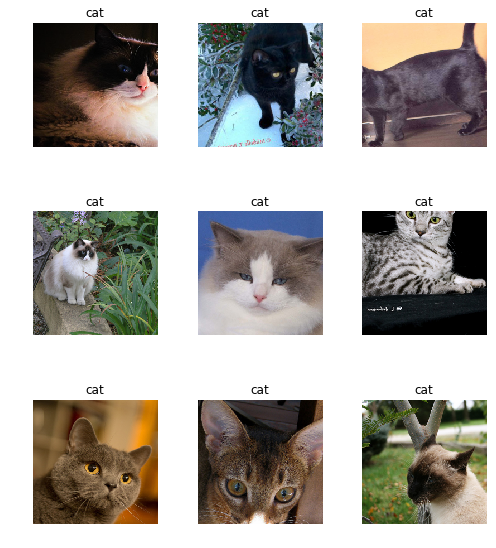

In [140]:
data.show_batch(rows=3, figsize=(7,8))

# BUG - ImageDataBunch labels are incorrect

When I create the ImageDataBunch with an unbalanced amount of data (ex: 2400 pictures of cats and 208 pictures with no cats). The data.show_batch() call appears to mislabel the data. Since the data heavily favors the cat category you need to may need to run it a couple of times before you see images that are clearly miscatagorized:

![alt text](./images/bad_data.png "bad data")
